<a href="https://colab.research.google.com/github/jaclynchiu7/EEG-Analysis/blob/main/EEG_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs260/assignments/assignment4/'
FOLDERNAME = 'ecengr 247'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [ ]:
# Check GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# 1 Loading and Preprocess Raw Data

 **SKIP TO RELOADING DATA SECTION FOR ALREADY PREPROCESSED DATA** 

---



In [ ]:
X_test = np.load("drive/MyDrive/ecengr 247/X_test.npy")
y_test = np.load("drive/MyDrive/ecengr 247/y_test.npy")
person_train_valid = np.load("drive/MyDrive/ecengr 247/person_train_valid.npy")
X_train_valid = np.load("drive/MyDrive/ecengr 247/X_train_valid.npy")
y_train_valid = np.load("drive/MyDrive/ecengr 247/y_train_valid.npy")
person_test = np.load("drive/MyDrive/ecengr 247/person_test.npy")


In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
# remap test labels 
# 0: left hand, 1: right hand, 2: feet, 3: tongue 
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_valid = label_encoder.fit_transform(y_train_valid)
y_test = label_encoder.fit_transform(y_test)

### Looking at Distribution of Data

Text(0, 0.5, 'count')

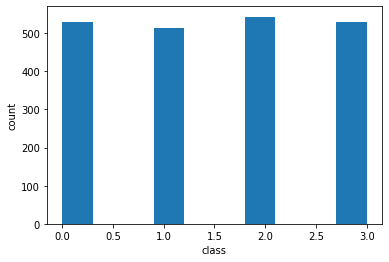

In [ ]:
# distribution of class across data 
plt.hist(y_train_valid)
plt.xlabel('class')
plt.ylabel('count')

Text(0, 0.5, 'count')

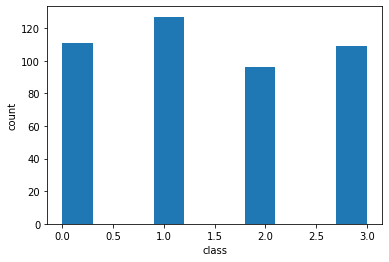

In [ ]:
plt.hist(y_test)
plt.xlabel('class')
plt.ylabel('count')

Text(0, 0.5, 'count')

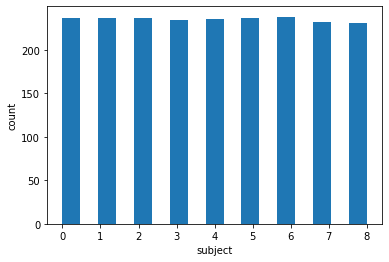

In [ ]:
# distribution of subjects across data 
plt.hist(person_train_valid, bins=np.linspace(0,8,num=18))
plt.xlabel('subject')
plt.ylabel('count')

Text(0, 0.5, 'count')

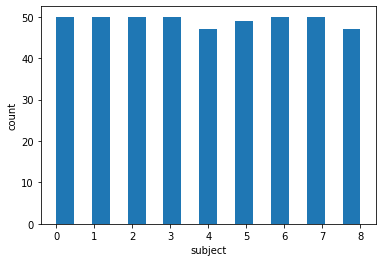

In [ ]:
plt.hist(person_test, bins=np.linspace(0,8,num=18))
plt.xlabel('subject')
plt.ylabel('count')

### Visualizing Data

[6, 18, 8, 15]


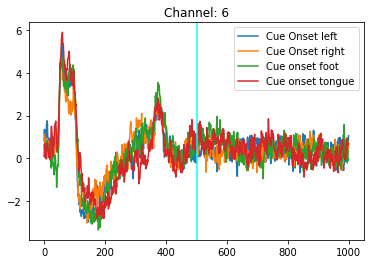

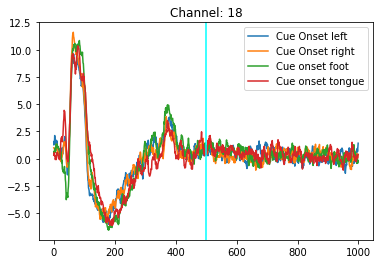

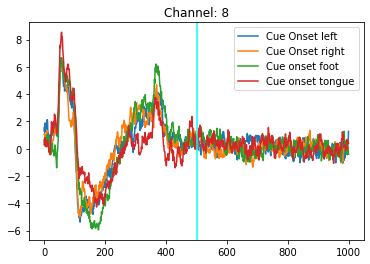

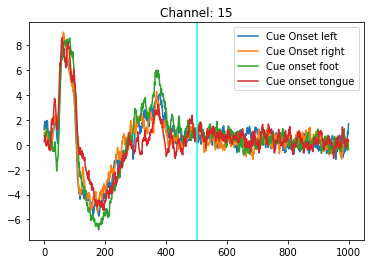

In [ ]:
import random
rand_channels = random.sample(range(0, 22), 4)
print(rand_channels)

for i in range(len(rand_channels)): # 4 random channels show similar graphs

  ch_data = X_train_valid[:,rand_channels[i],:] # extracts the 9th channel from the data

  class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
  ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
  avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


  class_1_ind = np.where(y_train_valid == 1)
  ch_data_class_1 = ch_data[class_1_ind]
  avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

  class_2_ind = np.where(y_train_valid == 2)
  ch_data_class_2 = ch_data[class_2_ind]
  avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

  class_3_ind = np.where(y_train_valid == 3)
  ch_data_class_3 = ch_data[class_3_ind]
  avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


  plt.plot(np.arange(1000),avg_ch_data_class_0)
  plt.plot(np.arange(1000),avg_ch_data_class_1)
  plt.plot(np.arange(1000),avg_ch_data_class_2)
  plt.plot(np.arange(1000),avg_ch_data_class_3)
  plt.axvline(x=500, label='line at t=500',c='cyan')

  plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])
  plt.title("Channel: " + str(rand_channels[i]))
  plt.show()

### Data Preprocessing

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


### Generating Training and Validation Data

In [ ]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)


### Variational AutoEncoder (VAE)

#### VAE architecture

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder 

latent_dim = 8
encoder_inputs = keras.Input(shape=(22, 250, 1), name='input_layer')
 
# Block-1
x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(encoder_inputs)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.LeakyReLU(name='lrelu_1')(x)
  
# Block-2
x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.LeakyReLU(name='lrelu_2')(x)
  
# Block-3
x = layers.Conv2D(64, 3, 1, padding='same', name='conv_3')(x)
x = layers.BatchNormalization(name='bn_3')(x)
x = layers.LeakyReLU(name='lrelu_3')(x)

# Block-4
x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
x = layers.BatchNormalization(name='bn_4')(x)
x = layers.LeakyReLU(name='lrelu_4')(x)

# Final Block
flatten = layers.Flatten()(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 22, 250, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv_1 (Conv2D)                (None, 22, 250, 32)  320         ['input_layer[0][0]']            
                                                                                                  
 bn_1 (BatchNormalization)      (None, 22, 250, 32)  128         ['conv_1[0][0]']                 
                                                                                                  
 lrelu_1 (LeakyReLU)            (None, 22, 250, 32)  0           ['bn_1[0][0]']             

In [ ]:
# Decoder 

latent_inputs = keras.Input(shape=(latent_dim,), name='input_layer')
x = layers.Dense(11*125*64, name='dense_1')(latent_inputs)
x = layers.Reshape((11, 125, 64), name='Reshape_Layer')(x)

# Block-1
x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.LeakyReLU(name='lrelu_1')(x)

# Block-2
x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.LeakyReLU(name='lrelu_2')(x)
  
# Block-3
x = layers.Conv2DTranspose(32, 3, 1, padding='same', name='conv_transpose_3')(x)
x = layers.BatchNormalization(name='bn_3')(x)
x = layers.LeakyReLU(name='lrelu_3')(x)
  
# Block-4
decoder_outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='elu', name='conv_transpose_4')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 8)]               0         
                                                                 
 dense_1 (Dense)             (None, 88000)             792000    
                                                                 
 Reshape_Layer (Reshape)     (None, 11, 125, 64)       0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 11, 125, 64)      36928     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 11, 125, 64)       256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 11, 125, 64)       0         
                                                           

In [ ]:
class VAE(keras.Model): # VAE class 
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.mse_loss_tracker = keras.metrics.Mean(
            name="mse_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.mse_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            mse_loss = tf.keras.backend.mean(tf.keras.backend.square(data-reconstruction), axis=[1, 2, 3])
            mse_loss *= 1000 #  scaling
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = mse_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.mse_loss_tracker.update_state(mse_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "mse_loss": self.mse_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

#### VAE Function

In [ ]:
def VAE_augmentation(X,y):
    
    total_X = X
    total_y = y

    # Class 0 VAE generation 
    class_0_idx = np.where(y == 0)[0]
    X_train_class_0 = X[class_0_idx, :, :]
    y_train_class_0= y[class_0_idx]
    x_class0 = np.expand_dims(X_train_class_0, -1).astype("float32")/255.0
    vae_class0 = VAE(encoder, decoder)
    vae_class0.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
    with tf.device('/device:GPU:0'):
      vae_class0.fit(x_class0, epochs = 10)
    
    z_mean, _, _ = vae_class0.encoder.predict(x_class0)
    x_train_vae_class0 = vae_class0.decoder.predict(z_mean)
    y_train_vae_class0 = np.zeros(len(y_train_class_0))

    # Class 1 VAE generation 
    class_1_idx = np.where(y == 1)[0]
    X_train_class_1 = X[class_1_idx, :, :]
    y_train_class_1= y[class_1_idx]
    x_class1 = np.expand_dims(X_train_class_1, -1).astype("float32")/255.0
    vae_class1 = VAE(encoder, decoder)
    vae_class1.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
    with tf.device('/device:GPU:0'):
      vae_class1.fit(x_class1, epochs = 10)
    
    z_mean, _, _ = vae_class1.encoder.predict(x_class1)
    x_train_vae_class1 = vae_class1.decoder.predict(z_mean)
    y_train_vae_class1 = np.zeros(len(y_train_class_1))

    # Class 2 VAE generation 
    class_2_idx = np.where(y == 2)[0]

    X_train_class_2 = X[class_2_idx, :, :]
    y_train_class_2= y[class_2_idx]
    x_class2 = np.expand_dims(X_train_class_2, -1).astype("float32")/255.0
    vae_class2 = VAE(encoder, decoder)
    vae_class2.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
    with tf.device('/device:GPU:0'):
      vae_class2.fit(x_class2, epochs = 10)
    
    z_mean, _, _ = vae_class2.encoder.predict(x_class2)
    x_train_vae_class2 = vae_class2.decoder.predict(z_mean)
    y_train_vae_class2 = np.zeros(len(y_train_class_2))

    # Class 3 VAE generation 
    class_3_idx = np.where(y == 3)[0]

    X_train_class_3 = X[class_3_idx, :, :]
    y_train_class_3= y[class_3_idx]
    x_class3 = np.expand_dims(X_train_class_3, -1).astype("float32")/255.0
    vae_class3 = VAE(encoder, decoder)
    vae_class3.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
    with tf.device('/device:GPU:0'):
      vae_class3.fit(x_class3, epochs = 10)
    
    z_mean, _, _ = vae_class3.encoder.predict(x_class3)
    x_train_vae_class3 = vae_class3.decoder.predict(z_mean)
    y_train_vae_class3 = np.zeros(len(y_train_class_3))

    # Concatenating values
    # stacking X data
    vae_X = np.vstack((x_train_vae_class0, x_train_vae_class1))
    vae_X = np.vstack((vae_X , x_train_vae_class2))
    vae_X = np.vstack((vae_X , x_train_vae_class3))

    # stacking Y data
    vae_y = np.hstack((y_train_vae_class0, y_train_vae_class1))
    vae_y = np.hstack((vae_y, y_train_vae_class2))
    vae_y = np.hstack((vae_y, y_train_vae_class3))

    # stacking vae and original data
    vae_X, vae_y = shuffle(vae_X, vae_y)
    vae_X = vae_X.reshape(vae_X.shape[0], vae_X.shape[1], vae_X.shape[2]) # reshaping to original train data 
    total_X = np.vstack((X, vae_X))
    total_y = np.hstack((y, vae_y))
    
    return total_X,total_y

#### VAE data generation

In [ ]:
#Augmenting training data
x_train, y_train = VAE_augmentation(x_train,y_train)

Epoch 1/10
56/56 [==============================] - 17s 14ms/step - loss: 1.6848 - mse_loss: 1.6662 - kl_loss: 8.1729e-05
Epoch 2/10
56/56 [==============================] - 1s 10ms/step - loss: 1.6396 - mse_loss: 1.6291 - kl_loss: 9.5612e-06
Epoch 3/10
56/56 [==============================] - 1s 10ms/step - loss: 1.6301 - mse_loss: 1.6263 - kl_loss: 5.3421e-06
Epoch 4/10
56/56 [==============================] - 1s 10ms/step - loss: 1.6289 - mse_loss: 1.6231 - kl_loss: 5.0084e-06
Epoch 5/10
56/56 [==============================] - 1s 10ms/step - loss: 1.6185 - mse_loss: 1.6239 - kl_loss: 3.7849e-06
Epoch 6/10
56/56 [==============================] - 1s 10ms/step - loss: 1.6135 - mse_loss: 1.6226 - kl_loss: 2.7418e-06
Epoch 7/10
56/56 [==============================] - 1s 10ms/step - loss: 1.6306 - mse_loss: 1.6226 - kl_loss: 2.4640e-06
Epoch 8/10
56/56 [==============================] - 1s 10ms/step - loss: 1.6476 - mse_loss: 1.6239 - kl_loss: 3.2383e-06
Epoch 9/10
56/56 [=============

In [ ]:
#Augmenting validation data
x_valid, y_valid = VAE_augmentation(x_valid,y_valid)

Epoch 1/10
11/11 [==============================] - 6s 13ms/step - loss: 1.6848 - mse_loss: 1.6407 - kl_loss: 4.6275e-06
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 1.6283 - mse_loss: 1.6326 - kl_loss: 4.4758e-06
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 1.5929 - mse_loss: 1.6245 - kl_loss: 2.9044e-06
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 1.6463 - mse_loss: 1.6215 - kl_loss: 3.5302e-06
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 1.5632 - mse_loss: 1.6212 - kl_loss: 2.6958e-06
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 1.5904 - mse_loss: 1.6189 - kl_loss: 2.7825e-06
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 1.5997 - mse_loss: 1.6207 - kl_loss: 2.2406e-06
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 1.6150 - mse_loss: 1.6181 - kl_loss: 3.0100e-06
Epoch 9/10
11/11 [==============

In [ ]:
#Augmenting test data 
X_test_prep, y_test_prep = VAE_augmentation(X_test_prep,y_test_prep)

Epoch 1/10
14/14 [==============================] - 6s 26ms/step - loss: 1.6645 - mse_loss: 1.6368 - kl_loss: 4.3213e-06
Epoch 2/10
14/14 [==============================] - 0s 11ms/step - loss: 1.6414 - mse_loss: 1.6261 - kl_loss: 1.6476e-06
Epoch 3/10
14/14 [==============================] - 0s 10ms/step - loss: 1.6608 - mse_loss: 1.6251 - kl_loss: 1.6796e-06
Epoch 4/10
14/14 [==============================] - 0s 10ms/step - loss: 1.6323 - mse_loss: 1.6229 - kl_loss: 1.8435e-06
Epoch 5/10
14/14 [==============================] - 0s 12ms/step - loss: 1.6296 - mse_loss: 1.6222 - kl_loss: 1.4028e-06
Epoch 6/10
14/14 [==============================] - 0s 11ms/step - loss: 1.5786 - mse_loss: 1.6220 - kl_loss: 1.3752e-06
Epoch 7/10
14/14 [==============================] - 0s 11ms/step - loss: 1.5521 - mse_loss: 1.6204 - kl_loss: 1.3198e-06
Epoch 8/10
14/14 [==============================] - 0s 10ms/step - loss: 1.6538 - mse_loss: 1.6204 - kl_loss: 1.7732e-06
Epoch 9/10
14/14 [==============

In [ ]:
print('Shape of training data after VAE_augmentation:',x_train.shape)
print('Shape of training labels after VAE_augmentation:',y_train.shape)
print('Shape of validation data after VAE_augmentation:',x_valid.shape)
print('Shape of validation labels after VAE_augmentation:',y_valid.shape)
print('Shape of test data after VAE_augmentation:',X_test_prep.shape)
print('Shape of test labels after VAE_augmentation:',y_test_prep.shape)

Shape of training data after VAE_augmentation: (13920, 22, 250)
Shape of training labels after VAE_augmentation: (13920,)
Shape of validation data after VAE_augmentation: (3000, 22, 250)
Shape of validation labels after VAE_augmentation: (3000,)
Shape of test data after VAE_augmentation: (3544, 22, 250)
Shape of test labels after VAE_augmentation: (3544,)


### Reshaping training and Validation datasets

In [ ]:
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

# Reshaping the training and validation dataset
x_train_vae = np.swapaxes(x_train, 1,3)
x_train_vae = np.swapaxes(x_train, 1,2)
x_valid_vae = np.swapaxes(x_valid, 1,3)
x_valid_vae = np.swapaxes(x_valid, 1,2)
x_test_vae = np.swapaxes(x_test, 1,3)
x_test_vae = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training labels after categorical conversion: (13920, 4)
Shape of validation labels after categorical conversion: (3000, 4)
Shape of test labels after categorical conversion: (3544, 4)
Shape of training set after adding width info: (13920, 22, 250, 1)
Shape of validation set after adding width info: (3000, 22, 250, 1)
Shape of test set after adding width info: (3544, 22, 250, 1)
Shape of training set after dimension reshaping: (13920, 250, 1, 22)
Shape of validation set after dimension reshaping: (3000, 250, 1, 22)
Shape of test set after dimension reshaping: (3544, 250, 1, 22)


In [ ]:
# saving VAE data as npy files 
# np.save("drive/MyDrive/ecengr 247/Preprocessed_Data/x_train_vae.npy", x_train_vae)
# np.save("drive/MyDrive/ecengr 247/Preprocessed_Data/y_train_vae.npy", y_train_vae)
# np.save("drive/MyDrive/ecengr 247/Preprocessed_Data/x_valid_vae.npy", x_valid_vae)
# np.save("drive/MyDrive/ecengr 247/Preprocessed_Data/y_valid_vae.npy", y_valid_vae)
# np.save("drive/MyDrive/ecengr 247/Preprocessed_Data/x_test_vae.npy", x_test_vae)
# np.save("drive/MyDrive/ecengr 247/Preprocessed_Data/y_test_vae.npy", y_test_vae)

# 2 Reload Preprocessed Data

# 3 Neural Network Models with VAE

In [ ]:
x_train_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/x_train_vae.npy")
y_train_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/y_train_vae.npy")
x_valid_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/x_valid_vae.npy")
y_valid_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/y_valid_vae.npy")
x_test_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/x_test_vae.npy")
y_test_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/y_test_vae.npy")

## Basic CNN

In [ ]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 25)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 25)        100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 50)        0

In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [ ]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train_vae,
             y_train_vae,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_vae, y_valid_vae), verbose=True)

Epoch 1/50
218/218 [==============================] - 5s 8ms/step - loss: 1.0163 - accuracy: 0.6541 - val_loss: 0.6073 - val_accuracy: 0.7207
Epoch 2/50
218/218 [==============================] - 1s 7ms/step - loss: 0.7602 - accuracy: 0.6884 - val_loss: 0.5913 - val_accuracy: 0.7470
Epoch 3/50
218/218 [==============================] - 1s 7ms/step - loss: 0.6798 - accuracy: 0.7168 - val_loss: 0.5700 - val_accuracy: 0.7590
Epoch 4/50
218/218 [==============================] - 1s 7ms/step - loss: 0.6138 - accuracy: 0.7428 - val_loss: 0.5266 - val_accuracy: 0.7877
Epoch 5/50
218/218 [==============================] - 1s 7ms/step - loss: 0.5648 - accuracy: 0.7665 - val_loss: 0.5312 - val_accuracy: 0.7850
Epoch 6/50
218/218 [==============================] - 1s 7ms/step - loss: 0.5313 - accuracy: 0.7839 - val_loss: 0.4685 - val_accuracy: 0.8127
Epoch 7/50
218/218 [==============================] - 1s 7ms/step - loss: 0.5131 - accuracy: 0.7942 - val_loss: 0.4526 - val_accuracy: 0.8163
Epoch 

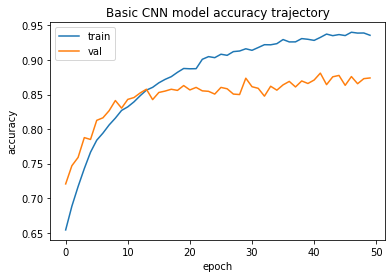

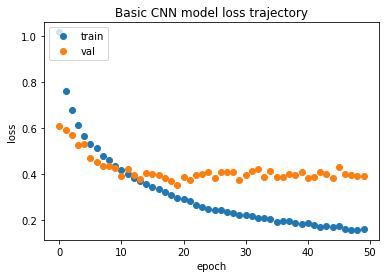

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test_vae, y_test_vae, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.8498871326446533


## Deep CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.layers import TimeDistributed

deep_cnn_model = Sequential()

# Conv. block 1
deep_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
deep_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu'))
deep_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
deep_cnn_model.add(BatchNormalization())
deep_cnn_model.add(Dropout(0.5))

# Conv. block 2
deep_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
deep_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
deep_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
deep_cnn_model.add(BatchNormalization())
deep_cnn_model.add(Dropout(0.5))

# Conv. block 3
deep_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
deep_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
deep_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
deep_cnn_model.add(BatchNormalization())
deep_cnn_model.add(Dropout(0.5))

# Conv. block 4
deep_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
deep_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
deep_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
deep_cnn_model.add(BatchNormalization())
deep_cnn_model.add(Dropout(0.5))

# FC layers
deep_cnn_model.add(Flatten())
deep_cnn_model.add(Dense(200, activation='relu'))
deep_cnn_model.add(Dropout(0.5))
deep_cnn_model.add(Dense(100, activation='relu'))
deep_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation 
deep_cnn_model.add(Dense(4, activation='softmax'))

# Printing the model summary
deep_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 conv2d_17 (Conv2D)          (None, 250, 1, 25)        6275      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 84, 1, 25)        0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 84, 1, 25)        100       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 84, 1, 50)        

In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [ ]:
# Compiling the model
deep_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
deep_cnn_model_results = deep_cnn_model.fit(x_train_vae,
             y_train_vae,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_vae, y_valid_vae), verbose=True)

Epoch 1/50
218/218 [==============================] - 3s 9ms/step - loss: 1.0538 - accuracy: 0.6214 - val_loss: 0.7168 - val_accuracy: 0.6570
Epoch 2/50
218/218 [==============================] - 2s 8ms/step - loss: 0.8035 - accuracy: 0.6402 - val_loss: 0.6498 - val_accuracy: 0.6997
Epoch 3/50
218/218 [==============================] - 2s 8ms/step - loss: 0.7139 - accuracy: 0.6667 - val_loss: 0.6107 - val_accuracy: 0.7230
Epoch 4/50
218/218 [==============================] - 2s 8ms/step - loss: 0.6478 - accuracy: 0.7030 - val_loss: 0.6111 - val_accuracy: 0.7213
Epoch 5/50
218/218 [==============================] - 2s 8ms/step - loss: 0.6118 - accuracy: 0.7241 - val_loss: 0.5563 - val_accuracy: 0.7503
Epoch 6/50
218/218 [==============================] - 2s 8ms/step - loss: 0.5845 - accuracy: 0.7455 - val_loss: 0.5666 - val_accuracy: 0.7523
Epoch 7/50
218/218 [==============================] - 2s 8ms/step - loss: 0.5628 - accuracy: 0.7630 - val_loss: 0.5519 - val_accuracy: 0.7673
Epoch 

In [ ]:
## Testing the deep CNN model

deep_cnn_score = deep_cnn_model.evaluate(x_test_vae, y_test_vae, verbose=0)
print('Test accuracy of the deep CNN model:',deep_cnn_score[1])

Test accuracy of the deep CNN model: 0.8143340945243835


## Shallow CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, Lambda
from keras import backend as K

def square_activation(x):
    return K.square(x)

def log_activation(x):
    return K.log(K.abs(x) + 1e-6)

shallow_cnn_model = Sequential()

# Conv. block 1
shallow_cnn_model.add(Conv2D(filters=40, kernel_size=(25,1), padding='same', activation='elu', input_shape=(250,1,22)))
shallow_cnn_model.add(BatchNormalization())
shallow_cnn_model.add(Dropout(0.5))

# Conv. block 2
shallow_cnn_model.add(Conv2D(filters=40, kernel_size=(25,1), padding='same', activation='elu'))
shallow_cnn_model.add(BatchNormalization())
shallow_cnn_model.add(Activation(square_activation))
shallow_cnn_model.add(AveragePooling2D(pool_size=(75,1), strides=(15,1), padding='same'))
shallow_cnn_model.add(Lambda(log_activation))

# FC layers
shallow_cnn_model.add(Flatten())
shallow_cnn_model.add(Dense(100, activation='elu'))

# Output layer with Softmax activation 
shallow_cnn_model.add(Dense(4, activation='softmax'))

# Printing the model summary
shallow_cnn_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 250, 1, 40)        22040     
                                                                 
 batch_normalization_28 (Bat  (None, 250, 1, 40)       160       
 chNormalization)                                                
                                                                 
 dropout_40 (Dropout)        (None, 250, 1, 40)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 250, 1, 40)        40040     
                                                                 
 batch_normalization_29 (Bat  (None, 250, 1, 40)       160       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 250, 1, 40)      

In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [ ]:
# Compiling the model
shallow_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
shallow_cnn_model_results = shallow_cnn_model.fit(x_train_vae,
             y_train_vae,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_vae, y_valid_vae), verbose=True)

Epoch 1/50
218/218 [==============================] - 2s 6ms/step - loss: 0.6486 - accuracy: 0.7184 - val_loss: 0.5549 - val_accuracy: 0.7730
Epoch 2/50
218/218 [==============================] - 1s 5ms/step - loss: 0.4483 - accuracy: 0.8182 - val_loss: 0.5285 - val_accuracy: 0.7970
Epoch 3/50
218/218 [==============================] - 1s 5ms/step - loss: 0.3397 - accuracy: 0.8677 - val_loss: 0.5151 - val_accuracy: 0.8217
Epoch 4/50
218/218 [==============================] - 1s 5ms/step - loss: 0.2477 - accuracy: 0.9063 - val_loss: 0.5950 - val_accuracy: 0.8110
Epoch 5/50
218/218 [==============================] - 1s 5ms/step - loss: 0.1846 - accuracy: 0.9340 - val_loss: 0.5886 - val_accuracy: 0.8143
Epoch 6/50
218/218 [==============================] - 1s 5ms/step - loss: 0.1272 - accuracy: 0.9561 - val_loss: 0.6429 - val_accuracy: 0.8060
Epoch 7/50
218/218 [==============================] - 1s 5ms/step - loss: 0.1083 - accuracy: 0.9618 - val_loss: 0.5980 - val_accuracy: 0.8233
Epoch 

In [ ]:
## Testing the shallow CNN model

shallow_cnn_score = shallow_cnn_model.evaluate(x_test_vae, y_test_vae, verbose=0)
print('Test accuracy of the shallow CNN model:',shallow_cnn_score[1])

Test accuracy of the shallow CNN model: 0.8055869340896606


## CNN-LSTM Hybrid

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical

# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 1, 50)       

In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 50
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [ ]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train_vae,
             y_train_vae,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_vae, y_valid_vae), verbose=True)

Epoch 1/50
218/218 [==============================] - 70s 308ms/step - loss: 0.9618 - accuracy: 0.6061 - val_loss: 0.8322 - val_accuracy: 0.6277
Epoch 2/50
218/218 [==============================] - 66s 302ms/step - loss: 0.6972 - accuracy: 0.6575 - val_loss: 0.6799 - val_accuracy: 0.6633
Epoch 3/50
218/218 [==============================] - 66s 305ms/step - loss: 0.6612 - accuracy: 0.6894 - val_loss: 0.6910 - val_accuracy: 0.7037
Epoch 4/50
218/218 [==============================] - 66s 303ms/step - loss: 0.6378 - accuracy: 0.7008 - val_loss: 0.6232 - val_accuracy: 0.7220
Epoch 5/50
218/218 [==============================] - 66s 303ms/step - loss: 0.6220 - accuracy: 0.7153 - val_loss: 0.6129 - val_accuracy: 0.7337
Epoch 6/50
218/218 [==============================] - 66s 304ms/step - loss: 0.6109 - accuracy: 0.7249 - val_loss: 0.6104 - val_accuracy: 0.7263
Epoch 7/50
218/218 [==============================] - 66s 304ms/step - loss: 0.5981 - accuracy: 0.7341 - val_loss: 0.6107 - val_ac

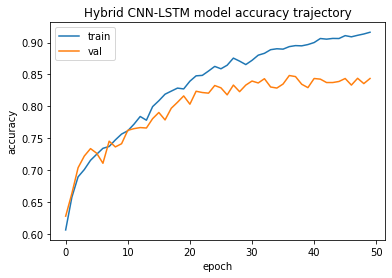

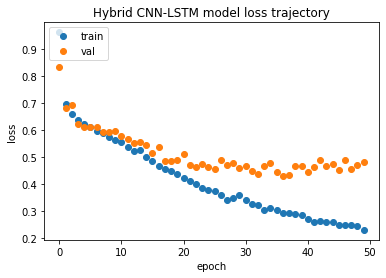

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test_vae, y_test_vae, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.8236455917358398


## CNN-GRU Hybrid

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.layers import GRU
from keras.utils import to_categorical

# Building the CNN model using sequential class
hybrid_cnn_gru_model = Sequential()

# Conv. block 1
hybrid_cnn_gru_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
hybrid_cnn_gru_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_gru_model.add(BatchNormalization())
hybrid_cnn_gru_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_gru_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_gru_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_gru_model.add(BatchNormalization())
hybrid_cnn_gru_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_gru_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_gru_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_gru_model.add(BatchNormalization())
hybrid_cnn_gru_model.add(Dropout(0.5))

# Conv. block 4
hybrid_cnn_gru_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_gru_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_gru_model.add(BatchNormalization())
hybrid_cnn_gru_model.add(Dropout(0.5))

# FC+GRU layers
hybrid_cnn_gru_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_gru_model.add(Dense((100))) # FC layer with 100 units
hybrid_cnn_gru_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_gru_model.add(GRU(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_gru_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_gru_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_25 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 28, 1, 50)       

In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 50
hybrid_cnn_gru_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [ ]:
# Compiling the model
hybrid_cnn_gru_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_gru_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_gru_model_results = hybrid_cnn_gru_model.fit(x_train_vae,
             y_train_vae,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_vae, y_valid_vae), verbose=True)

Epoch 1/50
218/218 [==============================] - 64s 282ms/step - loss: 0.8793 - accuracy: 0.6269 - val_loss: 0.7087 - val_accuracy: 0.6340
Epoch 2/50
218/218 [==============================] - 62s 283ms/step - loss: 0.7117 - accuracy: 0.6469 - val_loss: 0.6857 - val_accuracy: 0.6553
Epoch 3/50
218/218 [==============================] - 62s 285ms/step - loss: 0.6857 - accuracy: 0.6483 - val_loss: 0.6734 - val_accuracy: 0.6650
Epoch 4/50
218/218 [==============================] - 62s 284ms/step - loss: 0.6749 - accuracy: 0.6659 - val_loss: 0.6486 - val_accuracy: 0.6863
Epoch 5/50
218/218 [==============================] - 61s 280ms/step - loss: 0.6531 - accuracy: 0.6839 - val_loss: 0.6254 - val_accuracy: 0.7073
Epoch 6/50
218/218 [==============================] - 62s 282ms/step - loss: 0.6334 - accuracy: 0.6970 - val_loss: 0.6310 - val_accuracy: 0.7030
Epoch 7/50
218/218 [==============================] - 61s 281ms/step - loss: 0.6136 - accuracy: 0.7121 - val_loss: 0.6183 - val_ac

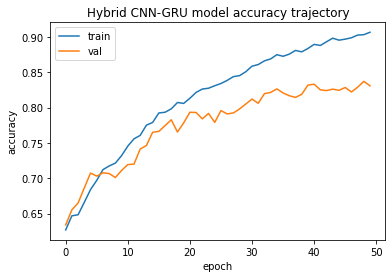

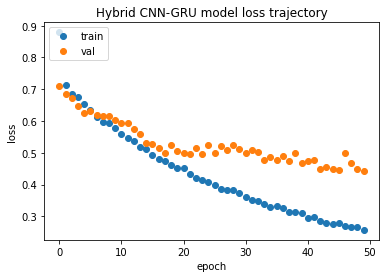

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_gru_model_results.history['accuracy'])
plt.plot(hybrid_cnn_gru_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-GRU model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot (hybrid_cnn_gru_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_gru_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-GRU model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the hybrid CNN-GRU model

hybrid_cnn_gru_score = hybrid_cnn_gru_model.evaluate(x_test_vae, y_test_vae, verbose=0)
print('Test accuracy of the hybrid CNN-GRU model:',hybrid_cnn_gru_score[1])

Test accuracy of the hybrid CNN-GRU model: 0.8267494440078735


## RNN-LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dropout, LSTM, Dense
from keras.optimizers import Adam

rnn_lstm_model = Sequential()
rnn_lstm_model.add(LSTM(64, input_shape=(250,22), return_sequences=True))
rnn_lstm_model.add(LSTM(32, return_sequences=True))

rnn_lstm_model.add(Flatten())
rnn_lstm_model.add(Dropout(0.5))
rnn_lstm_model.add(Dense(4, activation='softmax'))
rnn_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 250, 64)           22272     
                                                                 
 lstm_2 (LSTM)               (None, 250, 32)           12416     
                                                                 
 flatten_6 (Flatten)         (None, 8000)              0         
                                                                 
 dropout_29 (Dropout)        (None, 8000)              0         
                                                                 
 dense_15 (Dense)            (None, 4)                 32004     
                                                                 
Total params: 66,692
Trainable params: 66,692
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 50
rnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Compiling the model
rnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=rnn_optimizer,
                 metrics=['accuracy'])

x_train_rnn = np.squeeze(x_train_vae, axis=2)
x_valid_rnn = np.squeeze(x_valid_vae, axis=2)

# Training and validating the model
rnn_model_results = rnn_lstm_model.fit(x_train_rnn,
             y_train_vae,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_rnn, y_valid_vae), verbose=True)

Epoch 1/50
218/218 [==============================] - 8s 21ms/step - loss: 0.5443 - accuracy: 0.7800 - val_loss: 0.5025 - val_accuracy: 0.7933
Epoch 2/50
218/218 [==============================] - 4s 18ms/step - loss: 0.2876 - accuracy: 0.8930 - val_loss: 0.5460 - val_accuracy: 0.7980
Epoch 3/50
218/218 [==============================] - 4s 17ms/step - loss: 0.1695 - accuracy: 0.9399 - val_loss: 0.5879 - val_accuracy: 0.8090
Epoch 4/50
218/218 [==============================] - 4s 17ms/step - loss: 0.1038 - accuracy: 0.9638 - val_loss: 0.6590 - val_accuracy: 0.8067
Epoch 5/50
218/218 [==============================] - 4s 18ms/step - loss: 0.0653 - accuracy: 0.9774 - val_loss: 0.7231 - val_accuracy: 0.8040
Epoch 6/50
218/218 [==============================] - 4s 17ms/step - loss: 0.0575 - accuracy: 0.9806 - val_loss: 0.7407 - val_accuracy: 0.8063
Epoch 7/50
218/218 [==============================] - 4s 17ms/step - loss: 0.0475 - accuracy: 0.9824 - val_loss: 0.7541 - val_accuracy: 0.8020

In [ ]:
x_test_vae = np.squeeze(x_test_vae, axis=2)
rnn_lstm_score = rnn_lstm_model.evaluate(x_test_vae, y_test_vae, verbose=0)
print('Test accuracy of the RNN-LSTM model:',rnn_lstm_score[1])

Test accuracy of the RNN-LSTM model: 0.7880925536155701


## RNN-GRU

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dropout, GRU, Dense
from keras.optimizers import Adam

rnn_gru_model = Sequential()
rnn_gru_model.add(GRU(64, input_shape=(250,22), return_sequences=True))
rnn_gru_model.add(GRU(32, return_sequences=True))

rnn_gru_model.add(Flatten())
rnn_gru_model.add(Dropout(0.5))
rnn_gru_model.add(Dense(4, activation='softmax'))
rnn_gru_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 250, 64)           16896     
                                                                 
 gru_7 (GRU)                 (None, 250, 32)           9408      
                                                                 
 flatten_9 (Flatten)         (None, 8000)              0         
                                                                 
 dropout_32 (Dropout)        (None, 8000)              0         
                                                                 
 dense_18 (Dense)            (None, 4)                 32004     
                                                                 
Total params: 58,308
Trainable params: 58,308
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 50
rnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Compiling the model
rnn_gru_model.compile(loss='categorical_crossentropy',
                 optimizer=rnn_optimizer,
                 metrics=['accuracy'])


# Training and validating the model
rnn_gru_model_results = rnn_gru_model.fit(x_train_rnn,
             y_train_vae,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_rnn, y_valid_vae), verbose=True)

Epoch 1/50
218/218 [==============================] - 8s 22ms/step - loss: 0.5638 - accuracy: 0.7873 - val_loss: 0.6060 - val_accuracy: 0.7663
Epoch 2/50
218/218 [==============================] - 4s 17ms/step - loss: 0.2642 - accuracy: 0.9017 - val_loss: 0.6127 - val_accuracy: 0.7880
Epoch 3/50
218/218 [==============================] - 4s 17ms/step - loss: 0.1697 - accuracy: 0.9386 - val_loss: 0.6799 - val_accuracy: 0.7830
Epoch 4/50
218/218 [==============================] - 4s 17ms/step - loss: 0.1230 - accuracy: 0.9557 - val_loss: 0.7186 - val_accuracy: 0.7813
Epoch 5/50
218/218 [==============================] - 4s 17ms/step - loss: 0.0839 - accuracy: 0.9689 - val_loss: 0.7864 - val_accuracy: 0.7833
Epoch 6/50
218/218 [==============================] - 4s 17ms/step - loss: 0.0730 - accuracy: 0.9742 - val_loss: 0.8324 - val_accuracy: 0.7867
Epoch 7/50
218/218 [==============================] - 4s 17ms/step - loss: 0.0525 - accuracy: 0.9817 - val_loss: 0.9139 - val_accuracy: 0.7900

In [ ]:
rnn_gru_score = rnn_gru_model.evaluate(x_test_vae, y_test_vae, verbose=0)
print('Test accuracy of the RNN-GRU model:',rnn_gru_score[1])

Test accuracy of the RNN-GRU model: 0.7993792295455933


# 4 Tuning Hyperparameters for Basic CNN

## droupout tuning

In [ ]:
# Building the CNN model using sequential class
# Dropout = 0.6
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.6))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.6))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.6))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.6))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

basic_cnn_model_d6 = basic_cnn_model
# Printing the model summary
basic_cnn_model_d6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 84, 1, 25)        0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 84, 1, 25)        100       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 84, 1, 25)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 1, 50)       

In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Compiling the model
basic_cnn_model_d6.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_d6_results = basic_cnn_model_d6.fit(x_train_vae,
             y_train_vae,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_vae, y_valid_vae), verbose=True)

Epoch 1/50
218/218 [==============================] - 7s 8ms/step - loss: 1.1802 - accuracy: 0.6381 - val_loss: 0.7131 - val_accuracy: 0.6913
Epoch 2/50
218/218 [==============================] - 1s 6ms/step - loss: 0.8524 - accuracy: 0.6593 - val_loss: 0.6577 - val_accuracy: 0.6947
Epoch 3/50
218/218 [==============================] - 1s 6ms/step - loss: 0.7343 - accuracy: 0.6798 - val_loss: 0.6088 - val_accuracy: 0.7260
Epoch 4/50
218/218 [==============================] - 1s 6ms/step - loss: 0.6743 - accuracy: 0.7047 - val_loss: 0.5914 - val_accuracy: 0.7303
Epoch 5/50
218/218 [==============================] - 1s 6ms/step - loss: 0.6391 - accuracy: 0.7219 - val_loss: 0.5856 - val_accuracy: 0.7380
Epoch 6/50
218/218 [==============================] - 1s 6ms/step - loss: 0.6173 - accuracy: 0.7333 - val_loss: 0.5854 - val_accuracy: 0.7530
Epoch 7/50
218/218 [==============================] - 1s 7ms/step - loss: 0.5975 - accuracy: 0.7450 - val_loss: 0.5640 - val_accuracy: 0.7480
Epoch 

In [ ]:
## Testing the basic CNN model

cnn_score_d6 = basic_cnn_model_d6.evaluate(x_test_vae, y_test_vae, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score_d6[1])

Test accuracy of the basic CNN model: 0.8425508141517639


## Tune learning rate, batch size, epochs size

In [ ]:
# Building the CNN model using sequential class
def cnn_func(dropout):
  dp = dropout # set dropout value for tuning 
  basic_cnn_model = Sequential()

  # Conv. block 1
  basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(dp))

  # Conv. block 2
  basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(dp))

  # Conv. block 3
  basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(dp))

  # Conv. block 4
  basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(dp))

  # Output layer with Softmax activation
  basic_cnn_model.add(Flatten()) # Flattens the input
  basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  return basic_cnn_model


# Printing the model summary
# basic_cnn_model.summary()

In [ ]:
# Model parameters
# Tune 
learning_rates = [1e-2, 1e-3, 1e-4]
epochs = [25,50,75]
batch_sizes = [32, 64, 128]
dropout_values = [0.5, 0.6]
results = {}

In [ ]:
for lr in learning_rates:
  for epoch in epochs:
    for bs in batch_sizes:
      for drop in dropout_values:
        # Initiate CNN model 
        basic_cnn_model = cnn_func(drop)
        # Setting model parameters 
        cnn_optimizer = keras.optimizers.Adam(learning_rate = lr)
        basic_cnn_model.compile(loss='categorical_crossentropy',
                        optimizer=cnn_optimizer,
                        metrics=['accuracy'])

        # Training and validating the model
        basic_cnn_model.fit(x_train_vae,
                    y_train_vae,
                    batch_size=bs,
                    epochs=epoch,
                    validation_data=(x_valid_vae, y_valid_vae), verbose=False)
        # Testing model
        cnn_score = basic_cnn_model.evaluate(x_test_vae, y_test_vae, verbose=0)
        results[(lr, epoch, bs, drop)] = cnn_score[1]

        print("lr: ", str(lr), ", epoch: ", str(epoch), ", bs: ", str(bs), ", drop: ",str(drop),  " score is " ,str(cnn_score[1])) 

lr:  0.01 , epoch:  25 , bs:  32 , drop:  0.5  score is  0.8168736100196838
lr:  0.01 , epoch:  25 , bs:  32 , drop:  0.6  score is  0.815744936466217
lr:  0.01 , epoch:  25 , bs:  64 , drop:  0.5  score is  0.8442437648773193
lr:  0.01 , epoch:  25 , bs:  64 , drop:  0.6  score is  0.8219525814056396
lr:  0.01 , epoch:  25 , bs:  128 , drop:  0.5  score is  0.8397291302680969
lr:  0.01 , epoch:  25 , bs:  128 , drop:  0.6  score is  0.8301354646682739
lr:  0.01 , epoch:  50 , bs:  32 , drop:  0.5  score is  0.8431151509284973
lr:  0.01 , epoch:  50 , bs:  32 , drop:  0.6  score is  0.8470654487609863
lr:  0.01 , epoch:  50 , bs:  64 , drop:  0.5  score is  0.8301354646682739
lr:  0.01 , epoch:  50 , bs:  64 , drop:  0.6  score is  0.8481941223144531
lr:  0.01 , epoch:  50 , bs:  128 , drop:  0.5  score is  0.8354966044425964
lr:  0.01 , epoch:  50 , bs:  128 , drop:  0.6  score is  0.8450902700424194
lr:  0.01 , epoch:  75 , bs:  32 , drop:  0.5  score is  0.8448081016540527
lr:  0.01

In [ ]:
# print max accuracy and key
Keymax = max(zip(results.values(), results.keys()))[1]
print(Keymax)

(0.001, 75, 64, 0.6)


## Best performing basic CNN model:


*   Learning rate: 0.001
*   epoch: 75
*   batch size: 64
*   dropout: 0.6

